In [85]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os
import random
%matplotlib inline

print('...')


...


In [86]:
def get_dataset(rootdir):
    images = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(subdir, file))
                
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), images))

In [87]:
rootdir = 'labeled_data/vehicles/vehicles'
car_images  = get_dataset(rootdir)
print(len(car_images ))




8792


In [88]:
rootdir = 'labeled_data/non-vehicles/non-vehicles'
noncar_images= get_dataset(rootdir)
print(len(noncar_images))

8968


In [96]:
def show_images(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

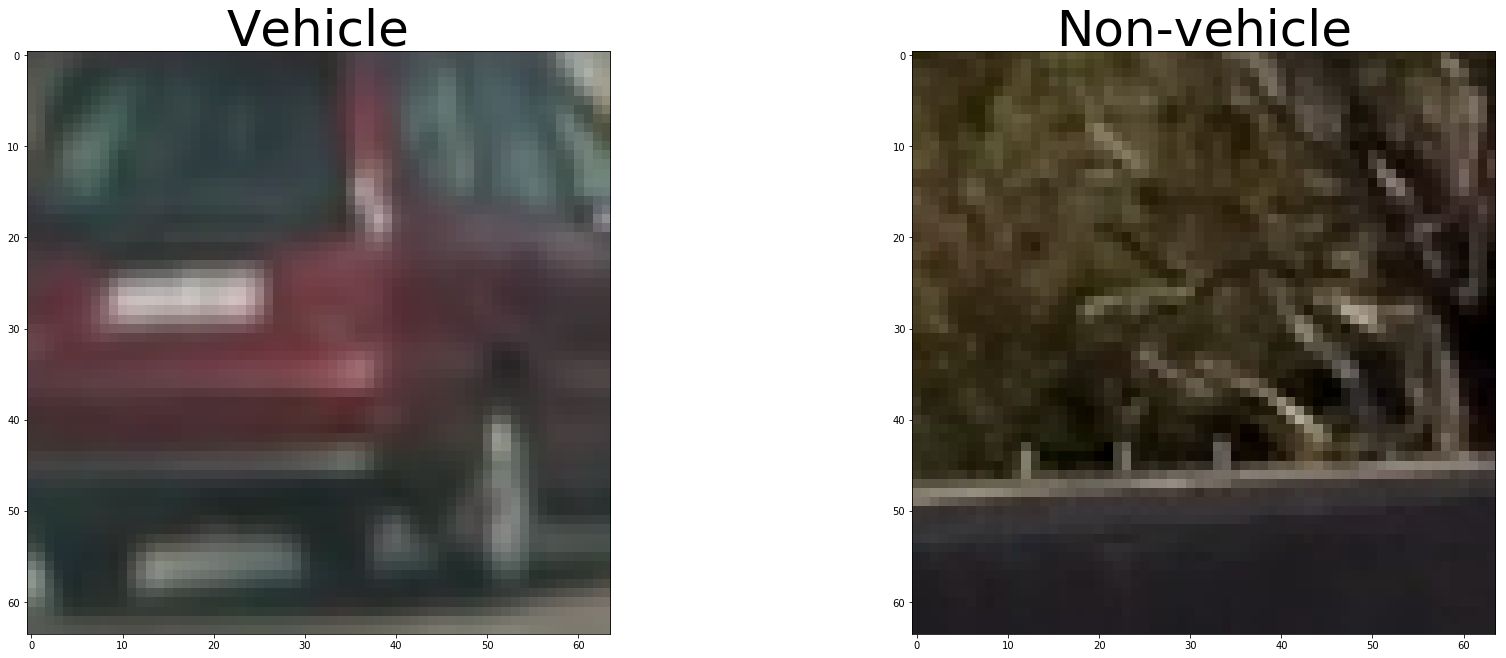

In [98]:
image1 = random.choice(car_images)
image2 = random.choice(noncar_images)
show_images(image1, "Vehicle", image2, "Non-vehicle")


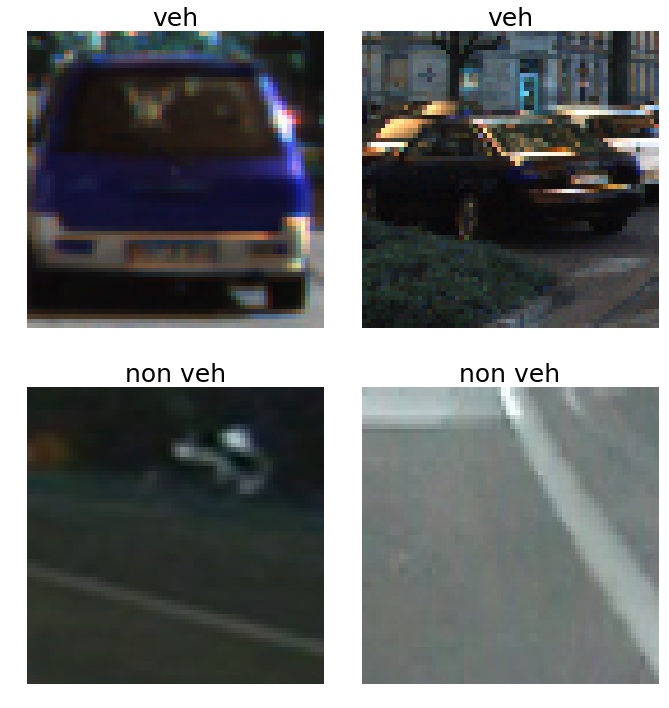

In [99]:
fig, axs = plt.subplots(2,2, figsize=(12, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(2):
    img = car_images[np.random.randint(0,len(car_images))]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('veh', fontsize=25)
    axs[i].imshow(img)
for i in np.arange(2,4):
    img = noncar_images[np.random.randint(0,len(noncar_images))]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non veh', fontsize=25)
    axs[i].imshow(img)

#### Histogram of Oriented Gradients (HOG)

In [100]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

...


#### Try HOG

...


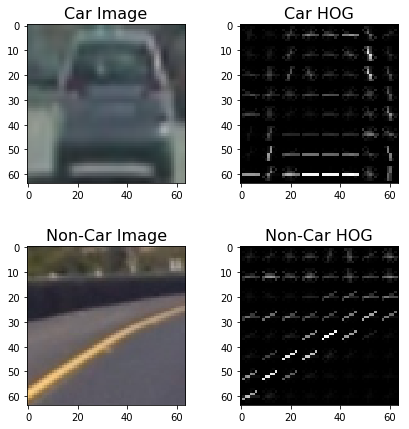

In [101]:
car_img =car_images[5]
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = noncar_images[5]
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

### Functions to extract Spatial, Color and HOG features

In [102]:


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
def convert_image(image, cspace):
    '''''
    Param: input image in RGB format
    Param: Desired image colorspace
    Returns: image in desired colorspace
    '''''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image) 
        
    return feature_image

# Define a function to extract features from a list of image locations

def extract_features(img, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel, size, hist_bins):
        # Create a list to append feature vectors to
    features = []
    feature_image = convert_image(img, cspace)  
    # Iterate through the list of images
    # Read in each one by one
    #image = mpimg.imread(file)
    # apply color conversion if other than 'RGB'
   
    hist_features = color_hist(feature_image, hist_bins)
    features.append(hist_features) 
    spatial_features = bin_spatial(feature_image, size)

    features.append(spatial_features)    
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(hog_features)
# Return list of feature vectors

    #print("hog_feat", len(hog_features))  
    
    return np.concatenate(features)

print('...')

...


#### Try on one image

In [105]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32,
scale = 1.5
hist_range = (0, 256)
       

t = time.time()


car_features_1 = extract_features(image1, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
notcar_features_1 = extract_features(image2, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)

Text(0.5,0,'Non-Car Spatial Features')

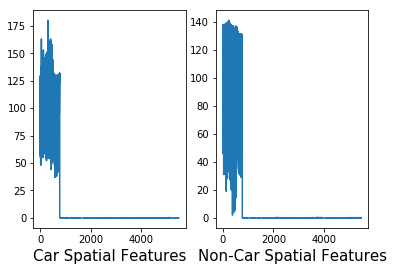

In [106]:
plt.figure()
plt.subplot(121)
plt.plot((car_features_1))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(notcar_features_1)
plt.xlabel("Non-Car Spatial Features",fontsize=15)

### Try feature extraction on all images

In [29]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32,
scale = 1.5
hist_range = (0, 256)
       

t = time.time()


car_features = list(map(lambda img: extract_features(img, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins), car_images[0:8750]))

notcar_features = list(map(lambda img: extract_features(img, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins), noncar_images[0:8750]))


print(len(car_features))
#print(car_features[100])
print(type(car_features))
#print(car_features.shape)
print(len(notcar_features))
print(type(notcar_features))
#print(notcar_features.shape)





8750
<class 'list'>
8750
<class 'list'>


Text(0.5,0,'Non-Car Spatial Features')

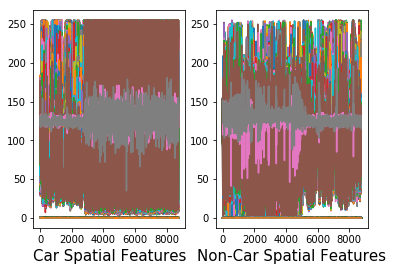

In [62]:
plt.figure()
plt.subplot(121)
plt.plot((car_features))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(notcar_features)
plt.xlabel("Non-Car Spatial Features",fontsize=15)


## Train SVC classifier

In [30]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("X : ",len(X))
print(type(X))
print(X.shape)

print("Y : ",len(y))
print(type(y))
print(y.shape)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and',cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

X :  17500
<class 'numpy.ndarray'>
(17500, 5472)
Y :  17500
<class 'numpy.ndarray'>
(17500,)
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5472
4.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9926


Text(0.5,0,'Label Y ')

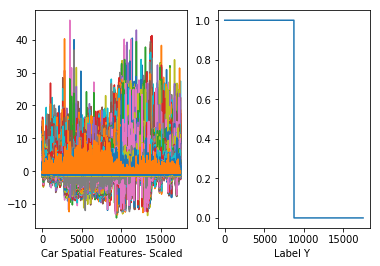

In [110]:
plt.figure()
plt.subplot(121)
plt.plot((scaled_X))
plt.xlabel("Car Spatial Features- Scaled",fontsize=10)

plt.subplot(122)
plt.plot(y)
plt.xlabel("Label Y ",fontsize=10)

### Sliding window function

In [31]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Find cars function

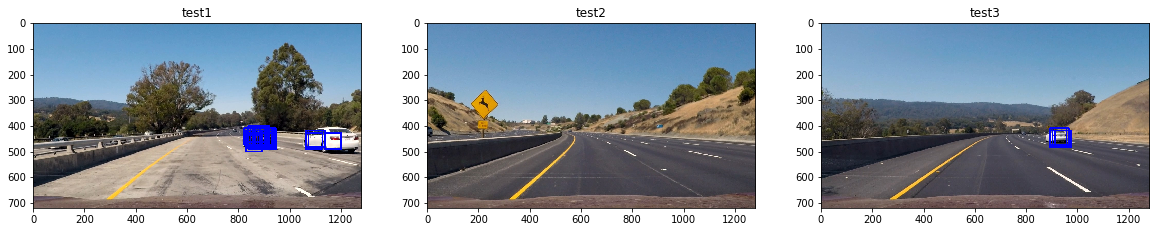

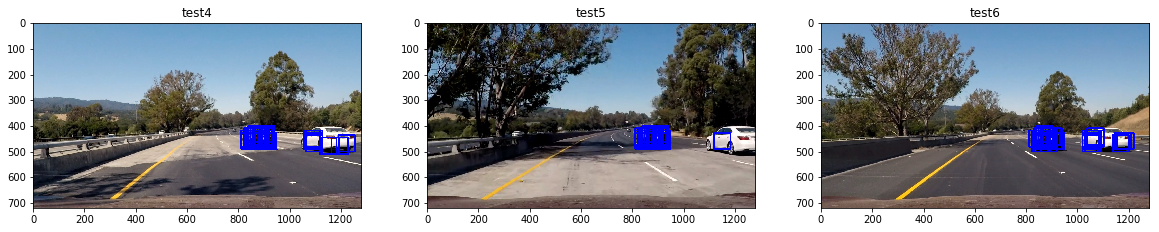

In [32]:
def findCars(img, svc,  scaler, cspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel, size,hist_bins, y_start_stop=[400, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    windows_list = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = svc.predict(scaled_features)
        if pred == 1:
            windows_list.append(window)
    return windows_list


#Run test images
test_images = ['./test_images/test1.jpg','./test_images/test2.jpg','./test_images/test3.jpg','./test_images/test4.jpg','./test_images/test5.jpg','./test_images/test6.jpg']
draw_images = []
for test_image in test_images:
    img = cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB)
    windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
    out_img = draw_boxes(img, windows_list)
    draw_images.append(out_img)
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('test1')
ax1.imshow(draw_images[0])
ax2.set_title('test2')
ax2.imshow(draw_images[1])
ax3.set_title('test3')
ax3.imshow(draw_images[2])
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(20,10))
ax4.set_title('test4')
ax4.imshow(draw_images[3])
ax5.set_title('test5')
ax5.imshow(draw_images[4])
ax6.set_title('test6')
ax6.imshow(draw_images[5])


###  Add heat and threshold to detect false positives

In [33]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [34]:
from scipy.ndimage.measurements import label

def heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel, size,hist_bins):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img, heatmap

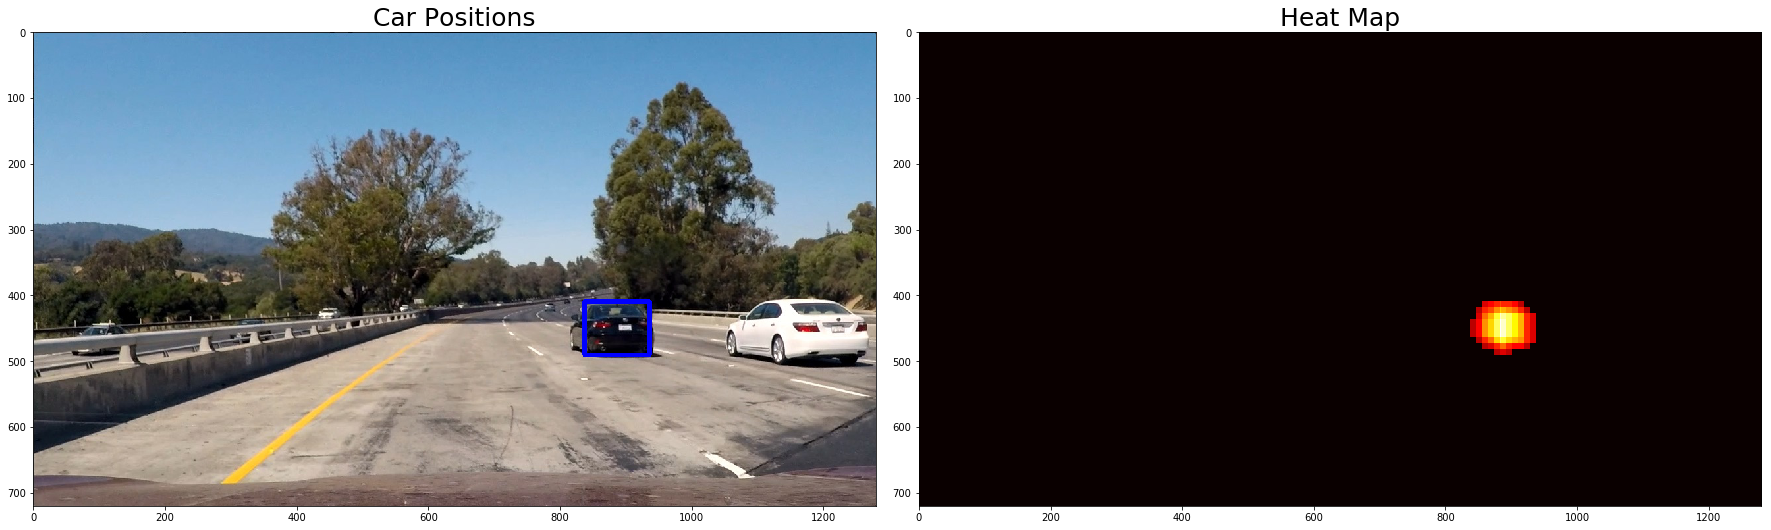

In [59]:
threshold = 4
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



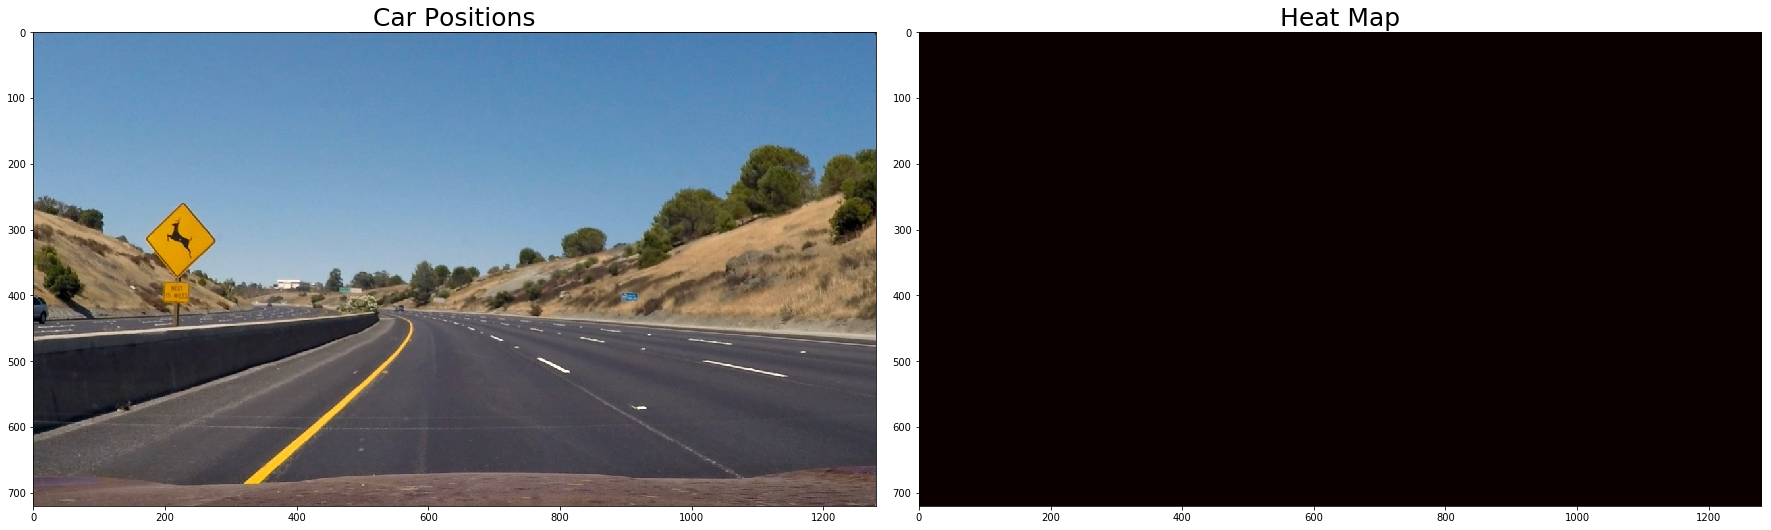

In [111]:
img = cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

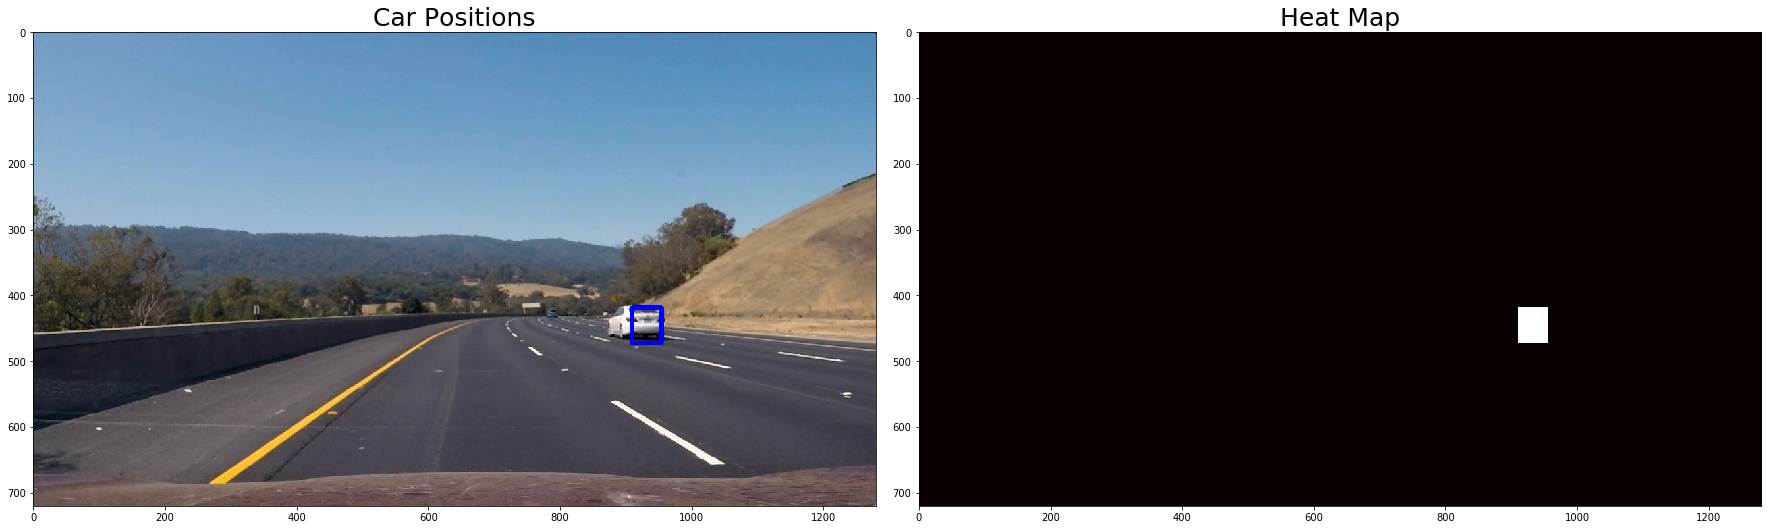

In [60]:
img = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

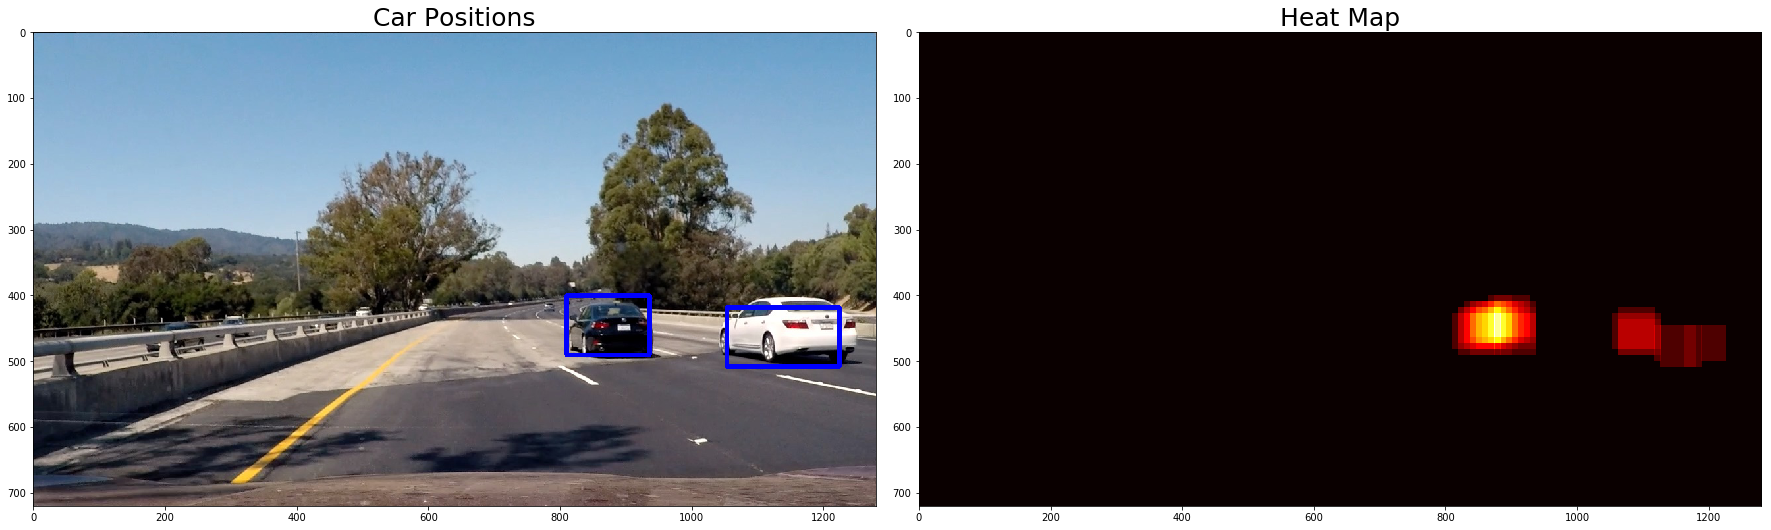

In [57]:
img = cv2.cvtColor(cv2.imread(test_images[3]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

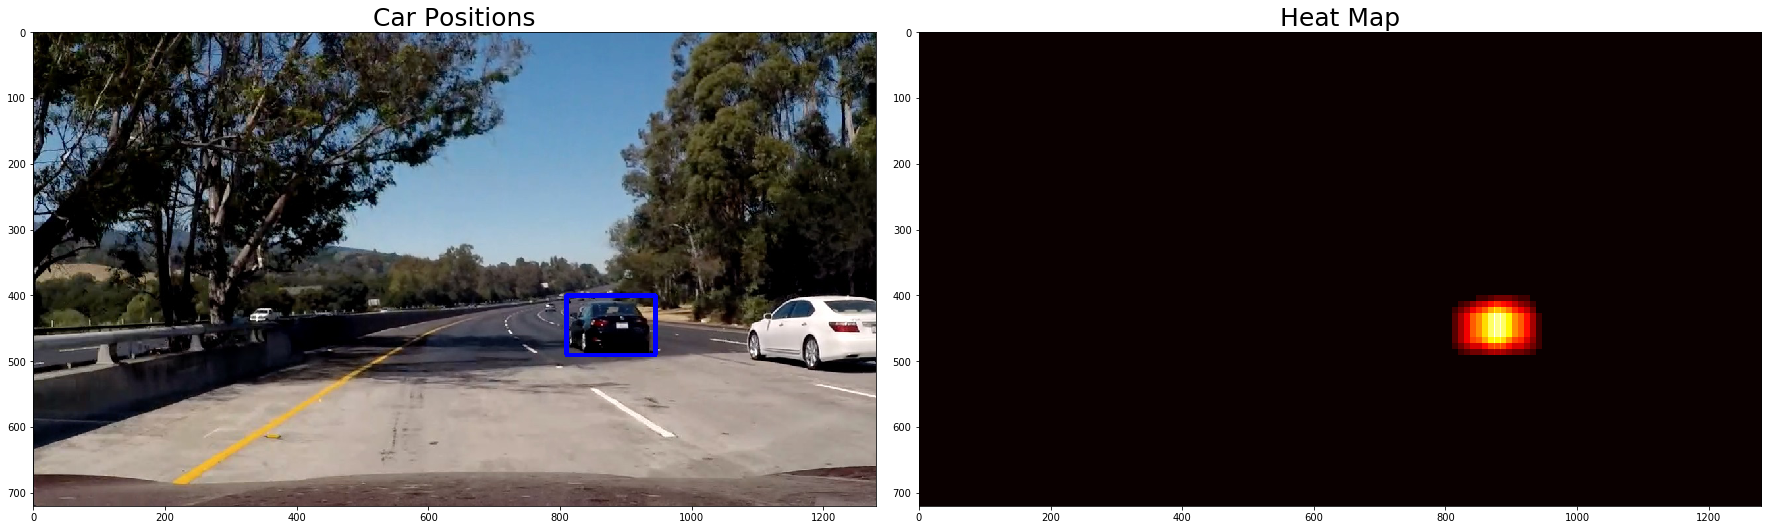

In [58]:




img = cv2.cvtColor(cv2.imread(test_images[4]), cv2.COLOR_BGR2RGB)
windows_list = findCars(img, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heatmap = heat_threshold(img, threshold, svc, X_scaler, windows_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### More efficient HOG sub sampling Sliding window search

In [39]:
def find_cars_hog_sub(img, ystart, ystop, svc, scaler, cspace, orient, 
                        pix_per_cell, cell_per_block, 
                        hog_channel,size,hist_bins, cells_per_step = 1):
    draw_img = np.copy(img)
    cspace = cspace
    
    img_tosearch = img[ystart:ystop,:,:]

    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale )
                ytop_draw = np.int(ytop*scale )
                win_draw = np.int(window*scale )
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

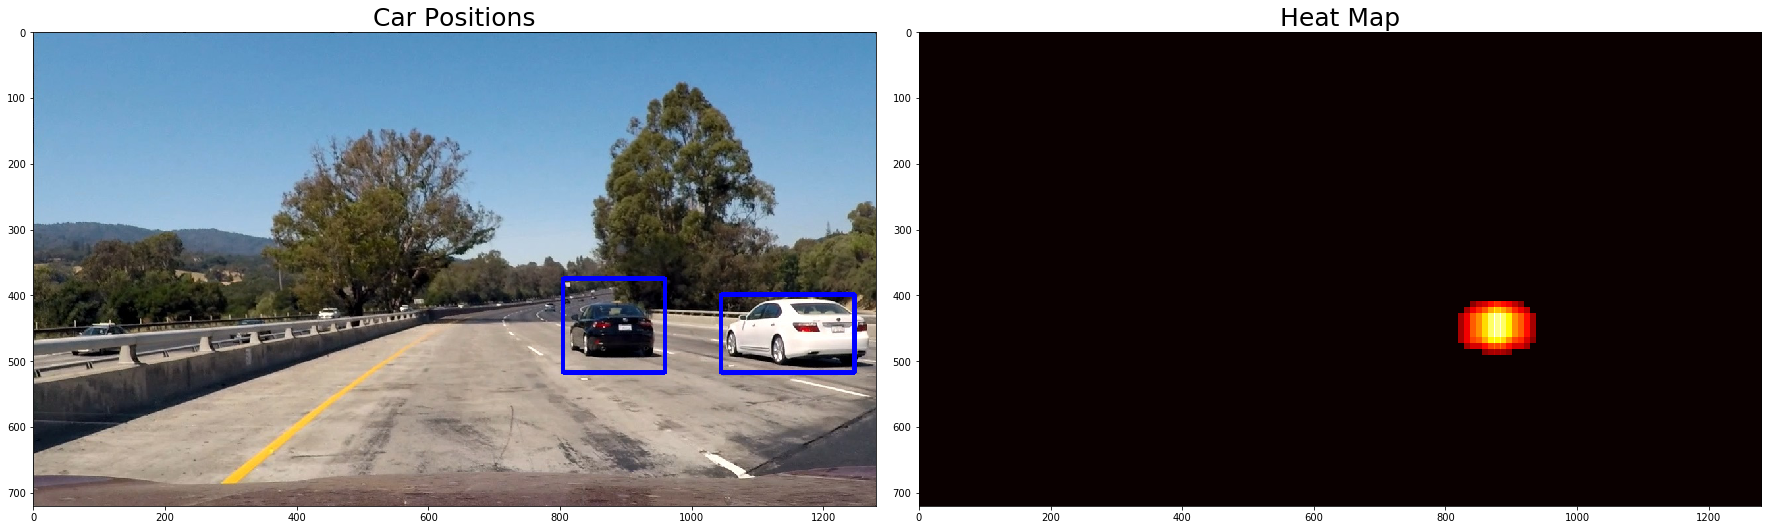

In [52]:
ystart = 350
ystop = 656

threshold = 1
img = cv2.cvtColor(cv2.imread(test_images[0]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


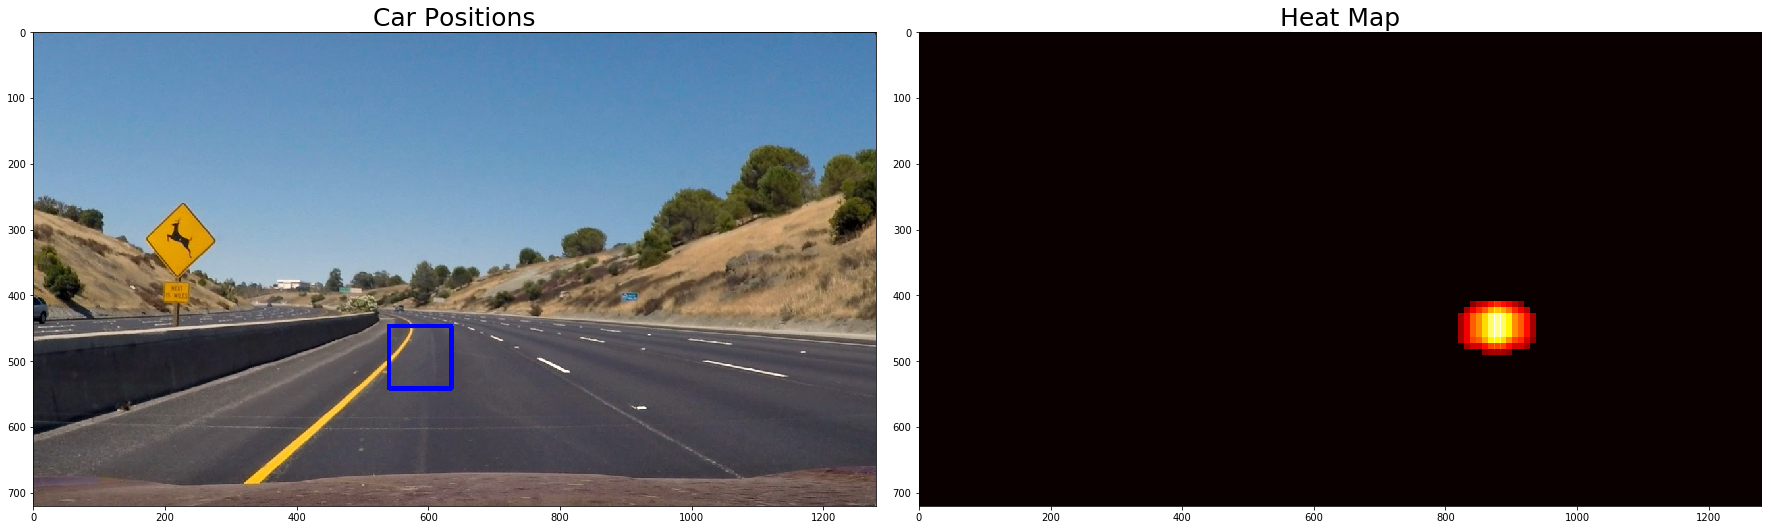

In [53]:
img = cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

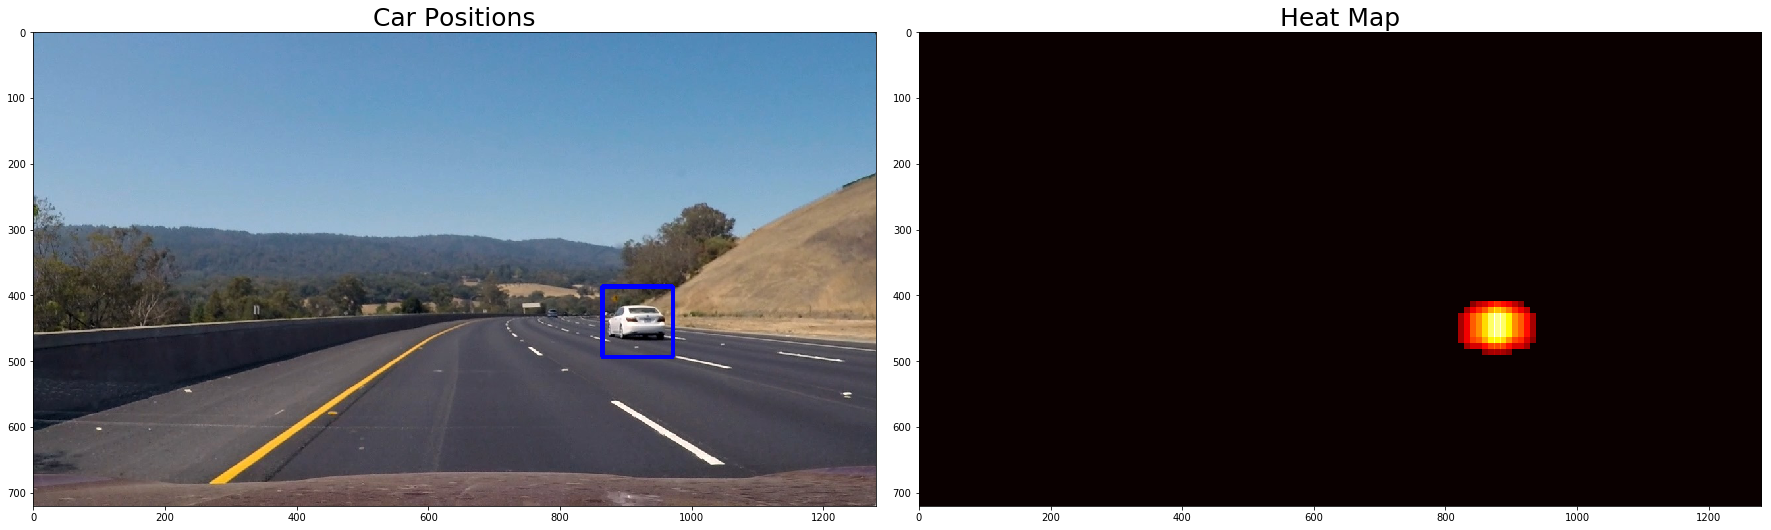

In [54]:
img = cv2.cvtColor(cv2.imread(test_images[2]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

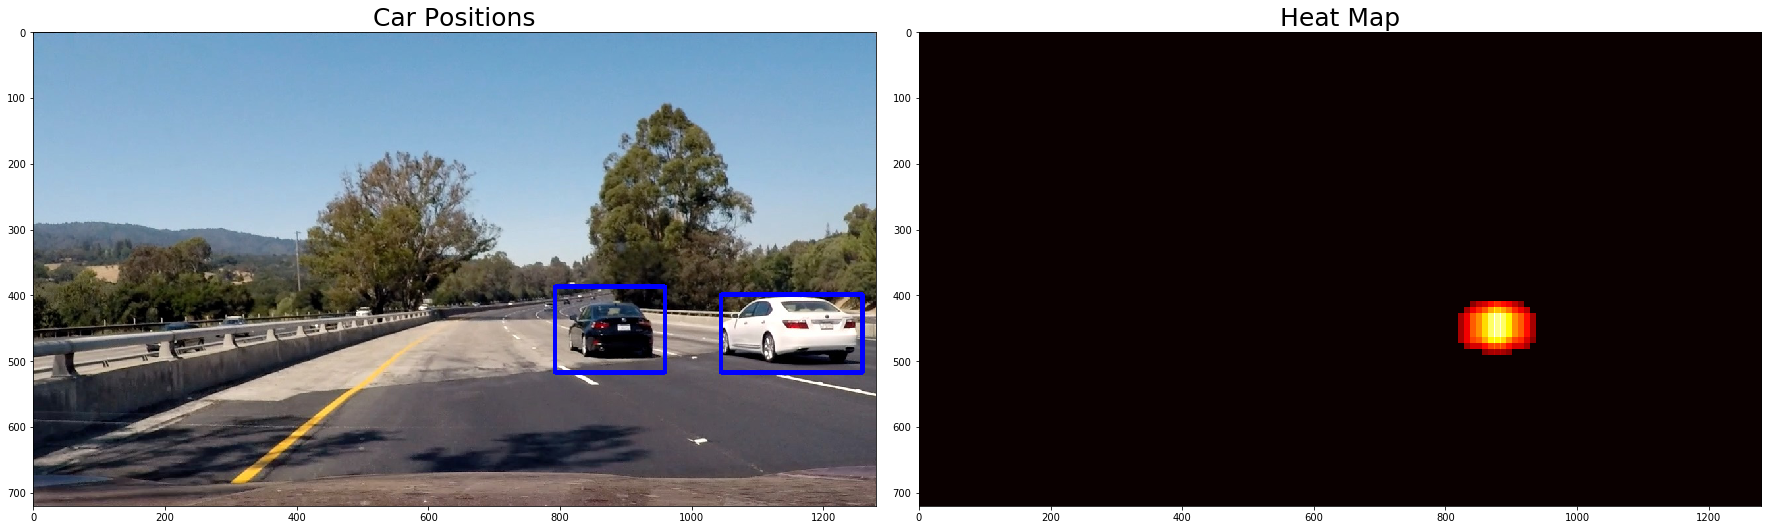

In [56]:
img = cv2.cvtColor(cv2.imread(test_images[3]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

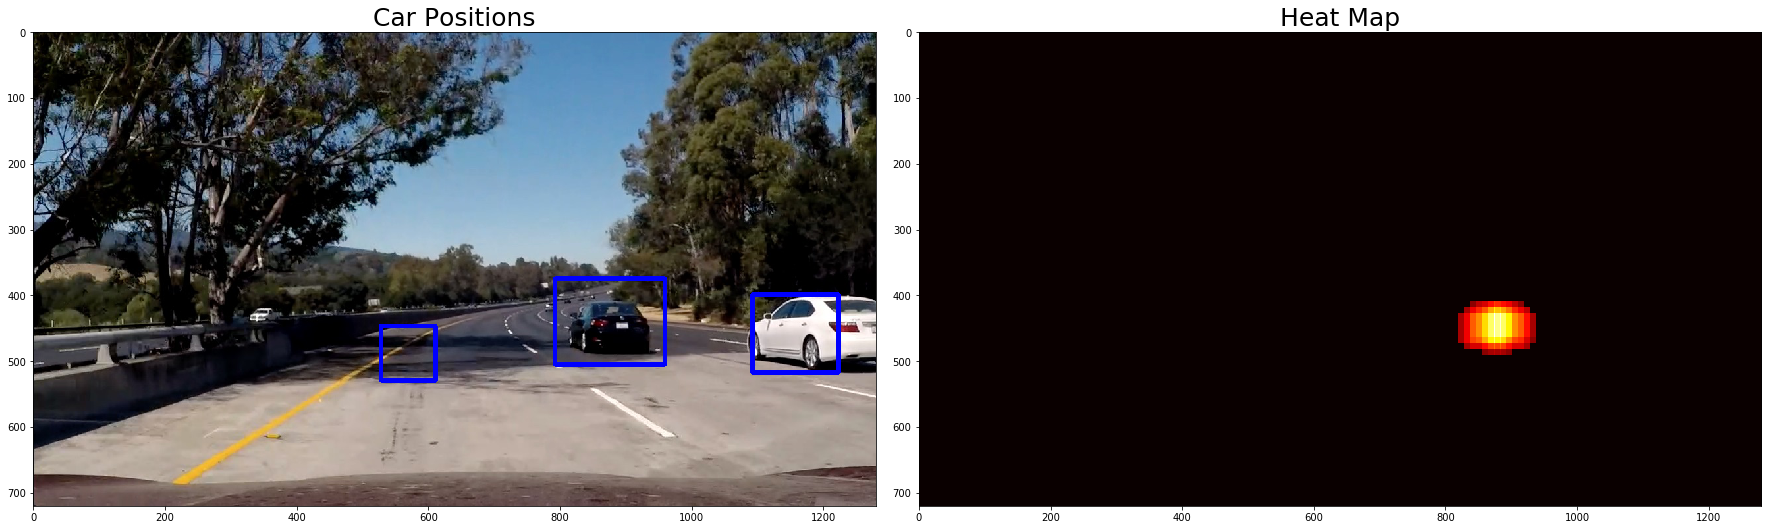

In [55]:
img = cv2.cvtColor(cv2.imread(test_images[4]), cv2.COLOR_BGR2RGB)    
car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(draw_img)
ax1.set_title('Car Positions', fontsize=25)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline to process the video

In [49]:
def pipeline(img):
    ystart = 350
    ystop = 656
    threshold = 1 
    car_windows = find_cars_hog_sub(img, ystart, ystop, svc, X_scaler, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
    draw_img, heat_map = heat_threshold(img, threshold, svc, X_scaler, car_windows, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,size=spatial_size,hist_bins=hist_bins)
    
    return draw_img

In [51]:
def process_image(img):
    return pipeline(img)

white_output = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [36:19<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

Wall time: 36min 19s
